In [1]:
import pandas as pd 
import joblib
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from autogluon.tabular import TabularPredictor
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, OneClassSVM
from sklearn.manifold import TSNE


2025-01-19 12:15:37.972478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 12:15:39.644828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vvhoang/ICS/AML/IEC 60870-5-104 datasets/TensorRT-10.0.1.6/lib:/home/vvhoang/ICS/AML/IEC 60870-5-104 datasets/TensorRT-10.0.1.6/lib:
2025-01-19 12:15:39.645493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; 

## Original Dataset

In [6]:
train_original = pd.read_csv('./DS/train_fold_3.csv')
test_original = pd.read_csv('./DS/test_fold_3.csv')

X_train_original = train_original.drop(['Label'], axis=1)
y_train_original = train_original['Label']
X_test_original = test_original.drop(['Label'], axis=1)
y_test_original = test_original['Label']
label_encoder = LabelEncoder()

y_test_original = label_encoder.fit_transform(y_test_original).astype(np.float32)
y_test_original = pd.Series(y_test_original)
y_train_original = label_encoder.fit_transform(y_train_original).astype(np.float32)
y_train_original = pd.Series(y_train_original)

rf_params = {
    "n_estimators": 70,
    "max_leaf_nodes": 370,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_original, y_train_original)
rf_prediction = rf.predict(X_test_original)

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test_original)
rf_precision = sklearn.metrics.precision_score(rf_prediction, y_test_original, average='macro')
rf_f1 = sklearn.metrics.f1_score(rf_prediction, y_test_original, average='macro')
rf_recall = sklearn.metrics.recall_score(rf_prediction, y_test_original, average='macro')
rf_cm = sklearn.metrics.confusion_matrix(rf_prediction, y_test_original)
rf_probs = rf.predict_proba(X_test_original)
rf_auc = sklearn.metrics.roc_auc_score(y_test_original, rf_probs, average='macro', multi_class='ovr')
print("RandomForest Accuracy:", rf_acc)
print("RandomForest Precision:", rf_precision)
print("RandomForest F1:", rf_f1)
print("RandomForest Recall:", rf_recall)
print("RandomForest ROC AUC:", rf_auc)
print("RandomForest CM:\n", rf_cm)

Training RandomForestClassifier
RandomForestClassifier Finished
RandomForest report:
RandomForest Accuracy: 0.8308678500986193
RandomForest Precision: 0.8308678500986194
RandomForest F1: 0.8248940434404961
RandomForest Recall: 0.8279808656873454
RandomForest ROC AUC: 0.9877012306461553
RandomForest CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   7   0   0   0   0   1   0   0   0   0]
 [  0   0 161   0   0   0   0  36   0  12   0   0]
 [  0   0   0 159   6   0   3   1   0   0   0   0]
 [  0   0   0   2 156   1   3   1   0   0   0   0]
 [  0   0   0   1   0 168   0   0   0   0   0   0]
 [  0   0   0   7   7   0 163   1   0   0   0   0]
 [  0   0   1   0   0   0   0  74  38   5   1   0]
 [  0   0   0   0   0   0   0  38 131   0   0   0]
 [  0   0   0   0   0   0   0  11   0 105 107   0]
 [  0   0   0   0   0   0   0   6   0  47  61   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]


# CovaS Framework

## 1. Performance Evaluation

### Autogluon

In [3]:
X_train_autogluon = X_train_original
X_train_autogluon['label'] = y_train_original
X_test_autogluon = X_test_original
X_test_autogluon['label'] = y_test_original

save_path = 'ag_models' 
predictor = TabularPredictor(path=save_path, label="label").fit(X_train_autogluon, num_gpus=1, verbosity=2)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "ag_models"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.8.19
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Apr 28 21:49:45 UTC 2021
CPU Count:          96
Memory Avail:       226.58 GB / 251.37 GB (90.1%)
Disk Space Avail:   43.95 GB / 1625.25 GB (2.7%)
Tr

In [4]:
preds = predictor.predict(X_test_original)
performance = predictor.evaluate_predictions(y_true=y_test_original, y_pred = preds, auxiliary_metrics=True)

ldb = predictor.leaderboard(X_test_autogluon)
print(ldb) 
print(performance)

                  model  score_test  score_val eval_metric  pred_time_test  \
0   WeightedEnsemble_L2    0.843688      0.758    accuracy        1.146771   
1        ExtraTreesEntr    0.836292      0.708    accuracy        0.345863   
2        ExtraTreesGini    0.834813      0.706    accuracy        0.350413   
3      RandomForestEntr    0.829882      0.734    accuracy        0.254866   
4      RandomForestGini    0.829389      0.734    accuracy        0.226548   
5         LightGBMLarge    0.825937      0.726    accuracy        0.017813   
6              LightGBM    0.813116      0.722    accuracy        0.016836   
7        KNeighborsDist    0.791420      0.586    accuracy        0.028086   
8            LightGBMXT    0.766765      0.730    accuracy        0.025892   
9              CatBoost    0.731755      0.744    accuracy        0.043505   
10              XGBoost    0.731262      0.720    accuracy        0.128992   
11       NeuralNetTorch    0.719428      0.728    accuracy      

### LSTM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score


train = pd.read_csv('./DS/train_fold_3.csv')
test = pd.read_csv('./DS/test_fold_3.csv')

In [2]:
class TabularLSTMDataset(Dataset):
    def __init__(self, data, target_col):
        # Separate features and target
        self.X = data.drop(columns=[target_col]).values
        self.y = data[target_col].values
        
        # Scale features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Convert to tensors
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMTabularModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        # Ensure input is 3D for LSTM
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

def train_lstm_model(train, test, target_col, task_type='multiclass', epochs=100, learning_rate=0.001):
    # Prepare datasets
    train_dataset = TabularLSTMDataset(train, target_col)
    test_dataset = TabularLSTMDataset(test, target_col)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Model initialization with dynamic input size
    input_size = train_dataset.X.shape[1]
    
    # Determine output size based on task type
    if task_type == 'regression':
        output_size = 1
    else:
        output_size = len(np.unique(train[target_col]))
    
    model = LSTMTabularModel(input_size=input_size, output_size=output_size)
    
    # Loss function based on task type
    if task_type == 'regression':
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.squeeze().long() if task_type != 'regression' else batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate training accuracy for classification
            if task_type != 'regression':
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y.squeeze().long()).sum().item()
        
        train_accuracy = (train_correct / train_total) * 100 if task_type != 'regression' else None
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%' if train_accuracy is not None else f'Loss: {total_loss/len(train_loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = []
        for batch_x, _ in test_loader:
            batch_pred = model(batch_x)
            test_preds.append(batch_pred)
        
        test_preds = torch.cat(test_preds).numpy()
    
    # Compute metrics
    if task_type == 'regression':
        true_labels = test[target_col].values if target_col in test.columns else None
        metrics = {
            'MSE': mean_squared_error(true_labels, test_preds) if true_labels is not None else None,
            'MAE': mean_absolute_error(true_labels, test_preds) if true_labels is not None else None,
            'R2': r2_score(true_labels, test_preds) if true_labels is not None else None
        }
    else:
        le = LabelEncoder()
        true_labels = le.fit_transform(test[target_col]) if target_col in test.columns else None
        
        # Convert predictions to class labels
        pred_labels = np.argmax(test_preds, axis=1)
        
        metrics = {
            'Accuracy': accuracy_score(true_labels, pred_labels) if true_labels is not None else None,
            'F1 Score': f1_score(true_labels, pred_labels, average='weighted') if true_labels is not None else None
        }
    
    # Create a copy of test to avoid modification
    test_with_preds = test.copy()
    test_with_preds['Predictions'] = pred_labels if task_type != 'regression' else test_preds
    
    return model, test_with_preds, metrics


def main():
    target_column = 'Label'
    task_type = 'multiclass'  # or 'binary' or 'regression'
    
    model, test_with_predictions, eval_metrics = train_lstm_model(
        train, test, target_column, task_type=task_type
    )
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    
    # Save predictions
    test_with_predictions.to_csv('./DL-model-preds/lstm_predictions.csv', index=False)

if __name__ == '__main__':
    main()

### DNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score

class TabularDataset(Dataset):
    def __init__(self, data, target_col):
        # Separate features and target
        self.X = data.drop(columns=[target_col]).values
        self.y = data[target_col].values
        
        # Scale features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Convert to tensors
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers=[128, 64, 32], output_size=1, dropout=0.3):
        super().__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


def train_dnn_model(train, test, target_col, task_type='multiclass', epochs=100, learning_rate=0.001):
    # Prepare datasets
    train_dataset = TabularDataset(train, target_col)
    test_dataset = TabularDataset(test, target_col)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Model initialization with dynamic input size
    input_size = train_dataset.X.shape[1]
    
    # Determine output size based on task type
    if task_type == 'regression':
        output_size = 1
    else:
        output_size = len(np.unique(train[target_col]))
    
    model = DeepNeuralNetwork(input_size=input_size, output_size=output_size)
    
    # Loss function based on task type
    if task_type == 'regression':
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.squeeze().long() if task_type != 'regression' else batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate training accuracy for classification
            if task_type != 'regression':
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y.squeeze().long()).sum().item()
        
        train_accuracy = (train_correct / train_total) * 100 if task_type != 'regression' else None
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, '
              f'Training Accuracy: {train_accuracy:.2f}%' if train_accuracy is not None else f'Loss: {total_loss/len(train_loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = []
        for batch_x, _ in test_loader:
            batch_pred = model(batch_x)
            test_preds.append(batch_pred)
        
        test_preds = torch.cat(test_preds).numpy()
    
    # Compute metrics
    if task_type == 'regression':
        true_labels = test[target_col].values if target_col in test.columns else None
        metrics = {
            'MSE': mean_squared_error(true_labels, test_preds) if true_labels is not None else None,
            'MAE': mean_absolute_error(true_labels, test_preds) if true_labels is not None else None,
            'R2': r2_score(true_labels, test_preds) if true_labels is not None else None
        }
    else:
        le = LabelEncoder()
        true_labels = le.fit_transform(test[target_col]) if target_col in test.columns else None
        
        # Convert predictions to class labels
        pred_labels = np.argmax(test_preds, axis=1)
        
        metrics = {
            'Accuracy': accuracy_score(true_labels, pred_labels) if true_labels is not None else None,
            'F1 Score': f1_score(true_labels, pred_labels, average='weighted') if true_labels is not None else None
        }
    
    # Create a copy of test to avoid modification
    test_with_preds = test.copy()
    test_with_preds['Predictions'] = pred_labels if task_type != 'regression' else test_preds
    
    return model, test_with_preds, metrics

def main():
    target_column = 'Label'
    task_type = 'multiclass'  # or 'binary' or 'regression'
    
    model, test_with_predictions, eval_metrics = train_dnn_model(
        train, test, target_column, task_type=task_type
    )
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    
    # Save predictions
    test_with_predictions.to_csv('./DL-model-preds/dnn_predictions.csv', index=False)

if __name__ == '__main__':
    main()

## 2. Histogram Overlap Computations

Total features with overlap < 70.0%: 34
Total features with overlap >= 70.0%: 77

Features with overlap < 70%:
flow idle time variance: 0.117
flow active time variance: 0.037
flow iec104 packts/s: 0.035
fw iec104 packts/s: 0.070
bw iec104 packts/s: 0.070
flow iec104 bytes/s: 0.009
fw iec104 bytes/s: 0.018
bw iec104 bytes/s: 0.018
fw packet APDU length var: 0.510
total flow packets: 0.230
total fw packets: 0.254
total bw packets: 0.244
flow packets APDU total length: 0.018
fw packets APDU total length: 0.018
bw packets APDU total length: 0.021
flow total IEC104_I_Message_SingleIOA packets: 0.254
fw total IEC104_I_Message_SingleIOA packets: 0.258
bw total IEC104_I_Message_SingleIOA packets: 0.328
fw PSH flag amount: 0.254
bw PSH flag amount: 0.244
flow PSH flag count: 0.230
flow ACK flag count: 0.230
fw_subflow_bytes: 0.096
bw_subflow_bytes: 0.122
fw avg bytes/bulk: 0.257
bw avg bytes/bulk: 0.298
fw avg bulk rate: 0.051
bw avg bulk rate: 0.021
init fw window bytes: 0.006
init bw window b

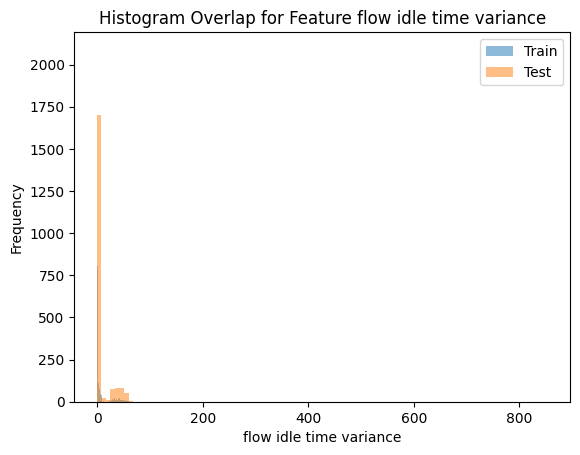

In [2]:
train = pd.read_csv('./DS/train_fold_3.csv')
test = pd.read_csv('./DS/test_fold_3.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

def histogram_overlap(a, b, bins=100):
    a_hist, _ = np.histogram(a, bins=bins, range=(a.min(), a.max()), density=True)
    b_hist, _ = np.histogram(b, bins=bins, range=(b.min(), b.max()), density=True)
    overlap = np.minimum(a_hist, b_hist).sum()
    return overlap

overlap_scores = {}
for feature in X_train.columns:
    overlap = histogram_overlap(X_train[feature], X_test[feature])
    overlap_scores[feature] = overlap

threshold = 0.70
low_overlap_features = {k: v for k, v in overlap_scores.items() if v < threshold}
high_overlap_features = {k: v for k, v in overlap_scores.items() if v >= threshold}

low_overlap_feature_names = list(low_overlap_features.keys())

print(f"Total features with overlap < {threshold*100}%: {len(low_overlap_features)}")
print(f"Total features with overlap >= {threshold*100}%: {len(high_overlap_features)}")

print("\nFeatures with overlap < 70%:")
for feature, overlap in low_overlap_features.items():
    print(f"{feature}: {overlap:.3f}")

if low_overlap_features:
    least_overlap_feature = next(iter(low_overlap_features))
    plt.hist(X_train[least_overlap_feature], bins=100, alpha=0.5, label='Train')
    plt.hist(X_test[least_overlap_feature], bins=100, alpha=0.5, label='Test')
    plt.legend(loc='upper right')
    plt.xlabel(least_overlap_feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram Overlap for Feature {least_overlap_feature}')
    plt.show()

In [6]:
low_overlap_feature_names

['flow idle time variance',
 'flow active time variance',
 'flow iec104 packts/s',
 'fw iec104 packts/s',
 'bw iec104 packts/s',
 'flow iec104 bytes/s',
 'fw iec104 bytes/s',
 'bw iec104 bytes/s',
 'fw packet APDU length var',
 'total flow packets',
 'total fw packets',
 'total bw packets',
 'flow packets APDU total length',
 'fw packets APDU total length',
 'bw packets APDU total length',
 'flow total IEC104_I_Message_SingleIOA packets',
 'fw total IEC104_I_Message_SingleIOA packets',
 'bw total IEC104_I_Message_SingleIOA packets',
 'fw PSH flag amount',
 'bw PSH flag amount',
 'flow PSH flag count',
 'flow ACK flag count',
 'fw_subflow_bytes',
 'bw_subflow_bytes',
 'fw avg bytes/bulk',
 'bw avg bytes/bulk',
 'fw avg bulk rate',
 'bw avg bulk rate',
 'init fw window bytes',
 'init bw window bytes',
 'fw TCP total header length',
 'bw TCP total header length',
 'cot=3',
 'type_id_process_information_in_monitor_direction']

In [7]:
autogluon_useless_features = ['flow packet APDU length min', 'flow total IEC104_I_Message_SeqIOA packets', 'fw total IEC104_I_Message_SeqIOA packets', 'bw total IEC104_I_Message_SeqIOA packets', 'fw URG flag amount', 'bw URG flag amount', 'flow SYN flag count', 'flow RST flag count', 'flow URG flag count', 'flow CWE flag count', 'flow ECE flag count', 'cot=2', 'cot=4', 'cot=5', 'cot=8', 'cot=9', 'cot=11', 'cot=12', 'cot=13', 'type_id_system_information_in_monitor_direction', 'type_id_parameter_in_control_direction', 'type_id_file_transfer', 'fw PSH flag amount', 'bw PSH flag amount', 'flow PSH flag count', 'flow ACK flag count']

combined_list = list(set(autogluon_useless_features + low_overlap_feature_names))

len(combined_list)

56

### Save DS after removing useless and overlap features

In [9]:
train = pd.read_csv('./DS/train_fold_3.csv')
test = pd.read_csv('./DS/test_fold_3.csv')

columns_to_remove = [
    'total flow packets',
    'bw_subflow_bytes',
    'bw total IEC104_I_Message_SeqIOA packets',
    'flow CWE flag count',
    'fw total IEC104_I_Message_SeqIOA packets',
    'fw_subflow_bytes',
    'cot=4',
    'type_id_file_transfer',
    'flow active time variance',
    'fw URG flag amount',
    'bw URG flag amount',
    'bw iec104 packts/s',
    'cot=2',
    'cot=3',
    'flow ACK flag count',
    'cot=5',
    'flow idle time variance',
    'cot=12',
    'flow PSH flag count',
    'flow total IEC104_I_Message_SeqIOA packets',
    'bw iec104 bytes/s',
    'flow SYN flag count',
    'flow URG flag count',
    'fw packets APDU total length',
    'fw avg bytes/bulk',
    'flow packets APDU total length',
    'type_id_system_information_in_monitor_direction',
    'flow iec104 packts/s',
    'cot=9',
    'bw PSH flag amount',
    'fw iec104 packts/s',
    'init bw window bytes',
    'total bw packets',
    'fw iec104 bytes/s',
    'type_id_parameter_in_control_direction',
    'bw avg bulk rate',
    'total fw packets',
    'bw avg bytes/bulk',
    'flow packet APDU length min',
    'flow ECE flag count',
    'cot=13',
    'cot=11',
    'flow RST flag count',
    'fw packet APDU length var',
    'fw avg bulk rate',
    'bw packets APDU total length',
    'flow iec104 bytes/s',
    'fw PSH flag amount',
    'flow total IEC104_I_Message_SingleIOA packets',
    'bw TCP total header length',
    'bw total IEC104_I_Message_SingleIOA packets',
    'fw TCP total header length',
    'fw total IEC104_I_Message_SingleIOA packets',
    'init fw window bytes',
    'cot=8',
    'type_id_process_information_in_monitor_direction'
]

train_modified = train.drop(columns=columns_to_remove, errors='ignore')
test_modified = test.drop(columns=columns_to_remove, errors='ignore')

train_modified.to_csv('./DS/train_remove_56_features.csv', index=False)
test_modified.to_csv('./DS/test_remove_56_features.csv', index=False)

print("Modified datasets saved successfully.")

Modified datasets saved successfully.


## 3. Kolomogorov Smirnov Test

In [2]:
train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

ks_results = {}
for feature in X_train.columns:
    statistic, p_value = ks_2samp(X_train[feature], X_test[feature])
    ks_results[feature] = (statistic, p_value)

# Filter features based on p-value < 0.05
significant_features = {k: v for k, v in ks_results.items() if v[1] < 0.05}

# Print the number of significant features
print(f"Total features with p-value < 0.05: {len(significant_features)}")

print("\nSignificant features (p-value < 0.05):")
for feature, (statistic, p_value) in significant_features.items():
    print(f"{feature}: KS Statistic = {statistic:.5f}, p-value = {p_value:.5f}")

critical_value = 1.36 * np.sqrt((len(X_train) + len(X_test)) / (len(X_train) * len(X_test)))
high_ks_features = {k: v for k, v in ks_results.items() if v[0] > critical_value}

print(f"Total features with KS Statistic > Critical value ({critical_value:.5f}): {len(high_ks_features)}")

print("\nFeatures with KS Statistic > Critical value:")
for feature, (statistic, p_value) in high_ks_features.items():
    print(f"{feature}: KS Statistic = {statistic:.5f}, p-value = {p_value:.5f}")

Total features with p-value < 0.05: 5

Significant features (p-value < 0.05):
flow idle time mean: KS Statistic = 0.03755, p-value = 0.03479
flow active time min: KS Statistic = 0.04550, p-value = 0.00526
flow IAT min: KS Statistic = 0.10987, p-value = 0.00000
fw IAT min: KS Statistic = 0.03716, p-value = 0.03784
bw IAT min: KS Statistic = 0.10632, p-value = 0.00000
Total features with KS Statistic > Critical value (0.03602): 5

Features with KS Statistic > Critical value:
flow idle time mean: KS Statistic = 0.03755, p-value = 0.03479
flow active time min: KS Statistic = 0.04550, p-value = 0.00526
flow IAT min: KS Statistic = 0.10987, p-value = 0.00000
fw IAT min: KS Statistic = 0.03716, p-value = 0.03784
bw IAT min: KS Statistic = 0.10632, p-value = 0.00000


## 4. 2D Visualiazation

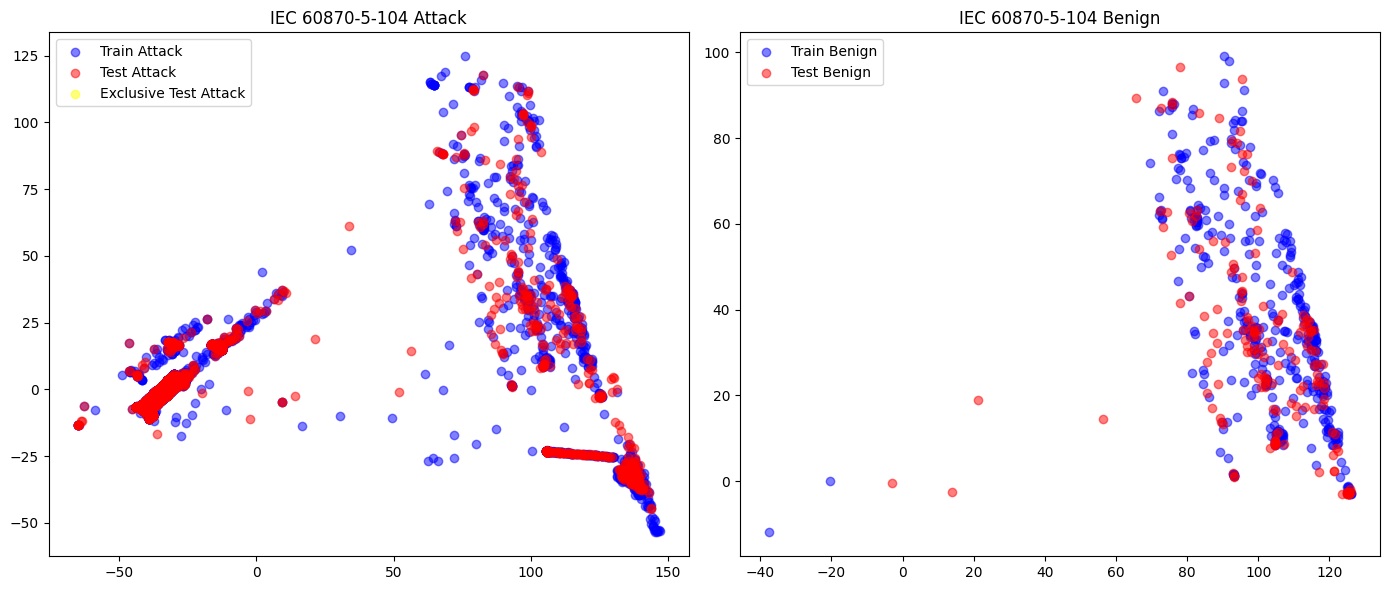

In [7]:
train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

X_pca_train = X_pca[:len(X_train)]
X_pca_test = X_pca[len(X_train):]

train_labels = set(y_train.unique())
test_labels = set(y_test.unique())
exclusive_test_attacks = test_labels - train_labels

train_attack = (y_train.isin(train_labels - exclusive_test_attacks))
test_attack = (y_test.isin(train_labels - exclusive_test_attacks))
exclusive_test_attack = (y_test.isin(exclusive_test_attacks))

train_benign = (y_train == 0)
test_benign = (y_test == 0)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca_train[train_attack, 0], X_pca_train[train_attack, 1], c='blue', alpha=0.5, label='Train Attack')
plt.scatter(X_pca_test[test_attack, 0], X_pca_test[test_attack, 1], c='red', alpha=0.5, label='Test Attack')
plt.scatter(X_pca_test[exclusive_test_attack, 0], X_pca_test[exclusive_test_attack, 1], c='yellow', alpha=0.5, label='Exclusive Test Attack')
plt.title('IEC 60870-5-104 Attack')
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_pca_train[train_benign, 0], X_pca_train[train_benign, 1], c='blue', alpha=0.5, label='Train Benign')
plt.scatter(X_pca_test[test_benign, 0], X_pca_test[test_benign, 1], c='red', alpha=0.5, label='Test Benign')
plt.title('IEC 60870-5-104 Benign')
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Discriminative Distance

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Load data
train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

# Prepare features and labels
X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

# Encode labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

# Combine train and test data for discriminative distance analysis
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([pd.Series(1, index=X_train.index), pd.Series(0, index=X_test.index)], axis=0)

# --- Random Forest Classifier ---
print("\n--- Random Forest ---")
rf_params = {
    "n_estimators": 500,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 42,
    "bootstrap": True,
    "criterion": "entropy"
}

rf_classifier = RandomForestClassifier(**rf_params)
cv_scores_rf = cross_val_score(rf_classifier, X_combined, y_combined, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (RF): {cv_scores_rf}")
print(f"Mean Cross-Validation Accuracy (RF): {np.mean(cv_scores_rf) * 100:.2f}%")

# --- XGBoost Classifier ---
print("\n--- XGBoost ---")
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
cv_scores_xgb = cross_val_score(xgb_classifier, X_combined, y_combined, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (XGBoost): {cv_scores_xgb}")
print(f"Mean Cross-Validation Accuracy (XGBoost): {np.mean(cv_scores_xgb) * 100:.2f}%")

# --- Extra Trees Classifier ---
print("\n--- Extra Trees ---")
et_params = {
    "n_estimators": 500,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 42,
    "bootstrap": True,
    "criterion": "entropy"
}

et_classifier = ExtraTreesClassifier(**et_params)
cv_scores_et = cross_val_score(et_classifier, X_combined, y_combined, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (Extra Trees): {cv_scores_et}")
print(f"Mean Cross-Validation Accuracy (Extra Trees): {np.mean(cv_scores_et) * 100:.2f}%")


--- Random Forest ---
Cross-Validation Accuracy Scores (RF): [0.68081991 0.62518302 0.66471449 0.63396779 0.59736457 0.7057101
 0.71303075 0.73060029 0.69354839 0.56451613]
Mean Cross-Validation Accuracy (RF): 66.09%

--- XGBoost ---


/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  w

Cross-Validation Accuracy Scores (XGBoost): [0.68374817 0.62079063 0.64860908 0.65885798 0.64568082 0.6954612
 0.68374817 0.71888726 0.69501466 0.40029326]
Mean Cross-Validation Accuracy (XGBoost): 64.51%

--- Extra Trees ---
Cross-Validation Accuracy Scores (Extra Trees): [0.6749634  0.63250366 0.66032211 0.62664714 0.58565154 0.69692533
 0.72181552 0.715959   0.67888563 0.70674487]
Mean Cross-Validation Accuracy (Extra Trees): 67.00%


In [5]:
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
# Load data
import pandas as pd
train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

# Encode labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

# Combine train and test data for discriminative distance analysis
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([pd.Series(1, index=X_train.index), pd.Series(0, index=X_test.index)], axis=0)
# Define Dataset Class
class TabularLSTMDataset(Dataset):
    def __init__(self, X, y):
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(X)
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define LSTM Model
class LSTMTabularModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

# Perform K-Fold Cross Validation
def train_lstm_kfold(X, y, task_type='multiclass', k=10, epochs=10, learning_rate=0.001):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    acc_scores = []
    f1_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = TabularLSTMDataset(X_train, y_train)
        val_dataset = TabularLSTMDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_size = X.shape[1]
        output_size = len(np.unique(y)) if task_type != 'regression' else 1
        model = LSTMTabularModel(input_size=input_size, output_size=output_size)
        
        criterion = nn.CrossEntropyLoss() if task_type != 'regression' else nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                # loss = criterion(outputs, batch_y.squeeze().long() if task_type != 'regression' else batch_y)
                loss = criterion(outputs, batch_y.view(-1).long() if task_type != 'regression' else batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluate model
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_pred = model(batch_x)
                pred_labels = torch.argmax(batch_pred, axis=1) if task_type != 'regression' else batch_pred.squeeze()
                all_preds.extend(pred_labels.numpy())
                all_labels.extend(batch_y.numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        acc_scores.append(acc)
        f1_scores.append(f1)
    
    print(f"Mean Accuracy (LSTM): {np.mean(acc_scores) * 100:.2f}%")
    print(f"Mean F1 Score (LSTM): {np.mean(f1_scores) * 100:.2f}%")
    return np.mean(acc_scores), np.mean(f1_scores)

# Run the LSTM model with KFold
mean_acc, mean_f1 = train_lstm_kfold(X_combined.values, y_combined.values, task_type='multiclass')


Mean Accuracy (LSTM): 70.49%
Mean F1 Score (LSTM): 60.37%


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Load data
train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

# Encode labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)

# Combine train and test data
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([pd.Series(1, index=X_train.index), pd.Series(0, index=X_test.index)], axis=0)

# Define Dataset Class
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(X)
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define DNN Model
class DNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout=0.3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

# Perform K-Fold Cross Validation
def train_dnn_kfold(X, y, task_type='multiclass', k=10, epochs=10, learning_rate=0.001):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    acc_scores = []
    f1_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = TabularDataset(X_train, y_train)
        val_dataset = TabularDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        input_size = X.shape[1]
        output_size = len(np.unique(y)) if task_type != 'regression' else 1
        model = DNNModel(input_size=input_size, output_size=output_size)
        
        criterion = nn.CrossEntropyLoss() if task_type != 'regression' else nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            model.train()
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y.view(-1).long() if task_type != 'regression' else batch_y)
                loss.backward()
                optimizer.step()
        
        # Evaluate model
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_pred = model(batch_x)
                pred_labels = torch.argmax(batch_pred, axis=1) if task_type != 'regression' else batch_pred.squeeze()
                all_preds.extend(pred_labels.numpy())
                all_labels.extend(batch_y.numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        acc_scores.append(acc)
        f1_scores.append(f1)
    
    print(f"Mean Accuracy (DNN): {np.mean(acc_scores) * 100:.2f}%")
    print(f"Mean F1 Score (DNN): {np.mean(f1_scores) * 100:.2f}%")
    return np.mean(acc_scores), np.mean(f1_scores)

# Run the DNN model with KFold
mean_acc, mean_f1 = train_dnn_kfold(X_combined.values, y_combined.values, task_type='multiclass')


Mean Accuracy (DNN): 70.53%
Mean F1 Score (DNN): 59.98%


## 6. SHAP based Feature Importance

In [2]:
import shap
from sklearn.ensemble import ExtraTreesClassifier

train = pd.read_csv('./DS/train_remove_56_features.csv')
test = pd.read_csv('./DS/test_remove_56_features.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_train = pd.Series(y_train)
labels = label_encoder.classes_

In [3]:
et_params = {
    "n_estimators": 300,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}


print("ExtraTreesClassifier Starting")
et_model = ExtraTreesClassifier(**et_params)
et_model.fit(X=X_train, y=y_train)
et_preds = et_model.predict(X_test)
et_acc = sklearn.metrics.accuracy_score(et_preds, y_test)
print("ExtraTreesClassifier Accuracy:", et_acc)

ExtraTreesClassifier Starting
ExtraTreesClassifier Accuracy: 0.8471400394477318


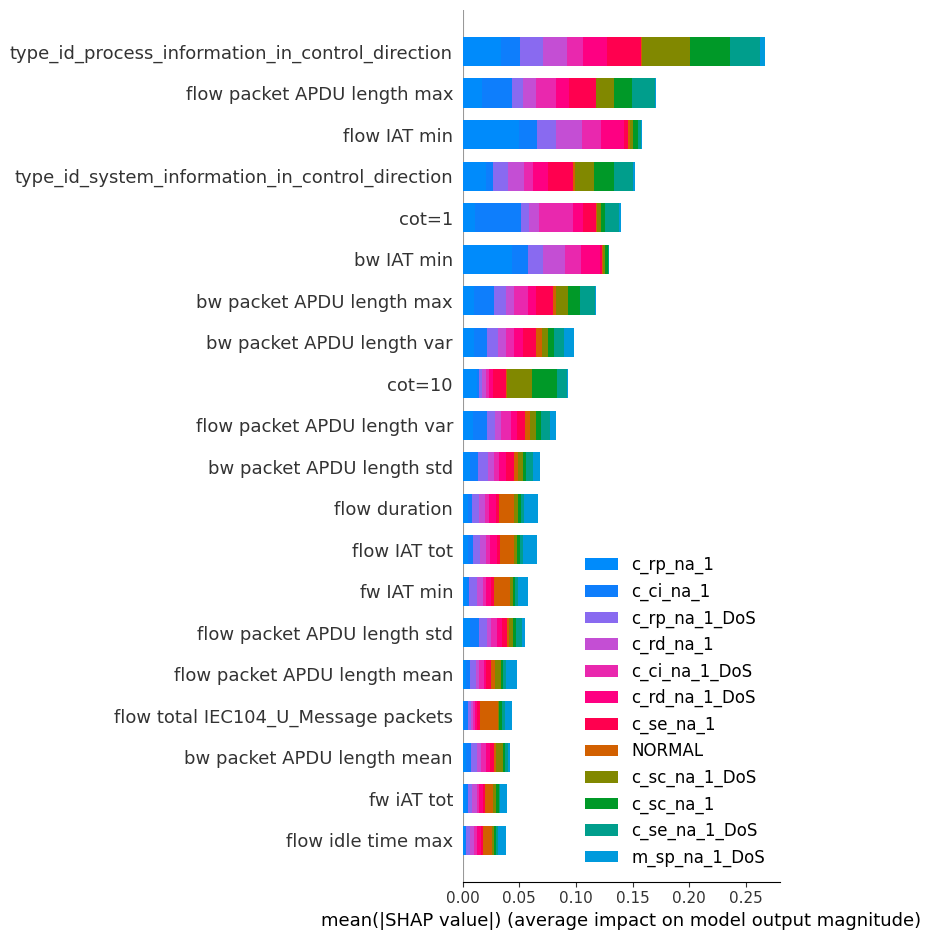

In [5]:
explainer = shap.Explainer(et_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=labels, show=False)

In [6]:
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=(0, 1))

feature_ranking = pd.DataFrame({'Feature': X_test.columns, 'Mean Absolute SHAP Value': mean_abs_shap_values})

feature_ranking = feature_ranking.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(feature_ranking)

                                             Feature  Mean Absolute SHAP Value
53  type_id_process_information_in_control_direction                  0.022245
23                       flow packet APDU length max                  0.014228
11                                      flow IAT min                  0.013166
54   type_id_system_information_in_control_direction                  0.012709
48                                             cot=1                  0.011672
13                                        bw IAT min                  0.010798
31                         bw packet APDU length max                  0.009806
35                         bw packet APDU length var                  0.008216
51                                            cot=10                  0.007774
26                       flow packet APDU length var                  0.006865
34                         bw packet APDU length std                  0.005714
36                                     flow duration

In [ ]:
threshold = 0.0005
selected_features = feature_ranking[feature_ranking['Mean Absolute SHAP Value'] > threshold]['Feature'].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print(len(selected_features))

In [4]:
selected_features = [
    'type_id_process_information_in_control_direction',
    'flow packet APDU length max',
    'flow IAT min',
    'type_id_system_information_in_control_direction',
    'cot=1',
    'bw IAT min',
    'bw packet APDU length max',
    'bw packet APDU length var',
    'cot=10',
    'flow packet APDU length var',
    'bw packet APDU length std',
    'flow duration',
    'flow IAT tot',
    'fw IAT min',
    'flow packet APDU length std',
    'flow packet APDU length mean',
    'flow total IEC104_U_Message packets',
    'bw packet APDU length mean',
    'fw iAT tot',
    'flow idle time max',
    'flow idle time std',
    'bw total IEC104_U_Message packets',
    'flow IAT mean',
    'flow IAT max',
    'fw total IEC104_U_Message packets',
    'fw IAT mean',
    'flow IAT std',
    'flow active time min',
    'flow total IEC104_S_Message packets',
    'flow idle time min',
    'fw IAT std',
    'flow idle time mean',
    'fw IAT max',
    'bw IAT max',
    'flow active time std',
    'flow active time max',
    'bw IAT std',
    'cot=6',
    'flow down/up ratio',
    'flow active time mean',
    'bw_subflow_packets',
    'bw IAT tot',
    'bw IAT mean',
    'fw packet APDU length mean',
    'fw_subflow_packets',
    'fw packet APDU length std',
    'bw total IEC104_S_Message packets',
    'fw packet APDU length min',
    'cot=7',
    'bw packet APDU length min',
    'cot=20'
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print(len(selected_features))

et_params = {
    "n_estimators": 300,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}


print("ExtraTrees Starting")
et_model = ExtraTreesClassifier(**et_params)
et_model.fit(X=X_train_selected, y=y_train)
# joblib.dump(et_model, f'./models/0.001_et_{len(selected_features)}.pkl')
et_preds = et_model.predict(X_test_selected)
et_acc = sklearn.metrics.accuracy_score(et_preds, y_test)
print("ExtraTrees Accuracy:", et_acc)

51
ExtraTrees Starting
ExtraTrees Accuracy: 0.8510848126232742


### LightGBM Evaluation

In [9]:
lgbm_params = {
  "learning_rate": 0.05,
  'num_boost_round': 8429,
  'device': 'gpu',
  'verbosity': -1
}

print("LightGBM Starting")
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model.fit(X=X_train_selected, y=y_train)
lgbm_prediction = lgbm_model.predict(X_test_selected)
lgbm_probs = lgbm_model.predict_proba(X_test_selected)
print("LightGBM Finished")

lgbm_acc = sklearn.metrics.accuracy_score(lgbm_prediction, y_test)
lgbm_precision = sklearn.metrics.precision_score(lgbm_prediction, y_test, average='macro')
lgbm_f1 = sklearn.metrics.f1_score(lgbm_prediction, y_test, average='macro')
lgbm_recall = sklearn.metrics.recall_score(lgbm_prediction, y_test, average='macro')
lgbm_cm = sklearn.metrics.confusion_matrix(lgbm_prediction, y_test)
lgbm_auc = sklearn.metrics.roc_auc_score(y_test, lgbm_probs, average='macro', multi_class='ovr')
print("LightGBM report:")
print("LightGBM Accuracy:", lgbm_acc)
print("LightGBM Precision:", lgbm_precision)
print("LightGBM F1:", lgbm_f1)
print("LightGBM Recall:", lgbm_recall)
print("LightGBM ROC AUC:", lgbm_auc)
print("LightGBM CM:\n", lgbm_cm)

LightGBM Starting


Found `num_boost_round` in params. Will use it instead of argument


LightGBM Finished
LightGBM report:
LightGBM Accuracy: 0.841715976331361
LightGBM Precision: 0.8417159763313609
LightGBM F1: 0.8355885355728558
LightGBM Recall: 0.8343934322236147
LightGBM ROC AUC: 0.984317192441908
LightGBM CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   0   0   0   0   0]
 [  0   0 169   0   0   0   0  35   0   8   0   0]
 [  0   0   0 169   0   0   0   5   0   1   0   0]
 [  0   0   0   0 169   0   0   2   0   2   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   1   0   0   0   0]
 [  0   0   0   0   0   0   0  61  47   7   0   0]
 [  0   0   0   0   0   0   0  43 122   0   0   0]
 [  0   0   0   0   0   0   0   9   0  89  86   0]
 [  0   0   0   0   0   0   0  13   0  62  83   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]


### Save DS

In [5]:
new_train = X_train_selected.copy()
new_train['Label'] = y_train
new_test = X_test_selected.copy()
new_test['Label'] = y_test

new_train.to_csv(f'./DS/train_shap_{len(selected_features)}.csv',index=False)
new_test.to_csv(f'./DS/test_shap_{len(selected_features)}.csv',index=False)